In [2]:
from IPython.display import HTML 
s="""<h1>2D Laplace Equation</h1></br><div id="toc"></div>
<script src="https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js" defer></script>""";
h=HTML(s); h

# Understand the Problem

* What is the 2D pressure field for the **Laplace equation** when the initial conditions are **zero everywhere** and the x-boundary conditions are 0 and 1  and the y-boundary conditions are von Neumann (zero gradient)?

* The Laplace Equation for pressure is described as follows:

$$ {\partial^2 p \over \partial x^2} + {\partial^2 p \over \partial y^2} = 0 $$

* This equation has an analytical solution:

$$ p(x,y) = {x \over 4} - 4 \sum_{m=1 (odd)}^\infty {{sinh(m \pi x) cos(m \pi y)} \over {(m \pi)^2sinh(2 \pi m)}} $$

***

# Formulate the Problem

## Input Data:

This problem has **no temporal component**, so we use a number of iterations.

* `niter` = 51 (maximum number of iterations)
* `nx` = 21 (number of x spatial points)
* `ny` = 11 (number of y spatial points)
* `xmax` = 2
* `ymax` = 1
* `infinity` = 100 (a large number)

## Initial Conditions:

* $\forall (x, y) \text{ if } n = 0 \rightarrow p = 0$

## Boundary Conditions:

* $\forall (n, y) \text{ if } x = 0 \rightarrow p = 0$
* $\forall (n, y) \text{ if } x = 2 \rightarrow p = y$
* $\forall (n, x) \text{ if } y = 0 \rightarrow {\partial p} / {\partial y} = 0$
* $\forall (n, x) \text{ if } y = 1 \rightarrow {\partial p} / {\partial y} = 0$

## Output Data:

* $\forall (x,y,n) \ p = ?$

***

# Design Algorithm to Solve Problem

## Space-time discretisation:

* i $\rightarrow$ index of grid in x
* j $\rightarrow$ index of grid in y
* n $\rightarrow$ index of iterations
* m $\rightarrow$ index of odd numbers in analytical solution

## Numerical scheme

* 2nd order CD in space

## Discrete equation

$$ {{p_{i+1,j}^n -2p_{i,j}^n + p_{i-1,j}^n} \over \Delta x^2} + 
{{p_{i,j+1}^n -2p_{i,j}^n + p_{i,j-1}^n} \over \Delta y^2} = 0 $$

## Transpose

$$ p_{i,j}^{n} = { {\Delta y^2 (p_{i+1,j}^{n}+p_{i-1,j}^{n}) + \Delta x^2 (p_{i,j+1}^{n}+p_{i,j-1}^{n})} \over {2(\Delta x^2 + \Delta y^2)} } $$
   
To use this as an iterative formula, $p_{i,j}^{n} = p_{i,j}^{n+1}$ **This looks a bit dodgy** but is the only thing that makes sense, unless we equate the RHS to forward differencing 

## Pseudo-code

    niter = 51 
    nx =  21
    xmax = 2
    ny = 11
    ymax = 1
    dx = xmax/(nx-1)
    dy = ymax/(ny-1)
    infinity = 100

    # Dirichlet Boundary Conditions

    # p boundary, left:
        p(0,:,:) = 0
    # p boundary, right:
        p(nx-1,:,:) = ymax 

    # von Neumann Boundary Conditions

    # Values for correction at boundaries:
    for j between 0 and ny-1
        jpos(j) = j + 1
        jneg(j) = j - 1
       
    # Set Reflection:
    # j:    -1  0,  1,... ny-2, ny-1, ny
    # jpos:         start =>    =>    end     
    # jneg: start =>  =>  end  

        jpos(ny-1) = ny-2 # i.e. ny = ny-2
        jneg(0) = 1       # i.e. -1 = 1
   
    # Initial Conditions

    p(:,:,0) = 0
   
    # Numerical Computation

    for n between 0 and niter-1
     for i between 1 and nx-1
        for j between 0 and ny
           p(i,j,n+1) = { dy^2 * [ p(i+1,j,n)+p(i-1,j,n) ] 
                      + dx^2 * [ p(i,jpos(j),n)+p(i,jneg(j),n) ] } 
                      / {2(dx^2 + dy^2)}


    # Analytical Solution 
    
    p_coefficient(i,j,1) = { 4 * [sinh(1*pi*x(i)]*[cos(1*pi*y(j)] } 
                         / { [(1*pi)**2]*sinh(2*pi*1) } 

    for m between 3 and infinity in odd steps
        for i between 0 and nx-1
            for j between 0 and ny-1
               p_coefficient(i,j) += {[sinh(m*pi*x(i)]*[cos(m*pi*y(j)] } 
                                  / { [(m*pi)**2]*sinh(2*pi*m) } 
  
    for i between 0 and nx-1
        p_analytical(i,j)= (x(i) / 4) - 4*p_coefficient(i,j)

***
# Implement Algorithm in Python

In [2]:
def laplace_equation_numerical(niter, nx, ny, xmax, ymax):

    """
    Returns the velocity field and distance for 2D linear convection
    """
    # Increments:
    dx = xmax/(nx-1)
    dy = ymax/(ny-1)

    # Initialise data structures:
    import numpy as np
    p = np.zeros(((nx,ny,niter)))
    x = np.zeros(nx)
    y = np.zeros(ny)
    jpos = np.zeros(ny)
    jneg = np.zeros(ny)

    # X Loop
    for i in range(0,nx):
        x[i] = i*dx

    # Y Loop
    for j in range(0,ny):
        y[j] = j*dy

    # Initial conditions
    p[:,:,0] = 0

    # Dirichlet Boundary Conditions:

    # p boundary, left:
    p[0,:,:] = 0

    # p boundary, right:
    for j in range(0,ny):
        p[nx-1,j,:] = y[j] 

    # von Neumann Boundary Conditions:

    # Values for correction at boundaries:
    for j in range(0,ny-1):
        jpos[j] = j + 1
        jneg[j] = j - 1

    # Set Reflection: 
    jpos[ny-1] = ny-2 
    jneg[0] = 1 

    # Loop
    for n in range(0,niter-1):
        for i in range(1,nx-1):
            for j in range(0,ny):
                p[i,j,n+1] = (( dy**2 * ( p[i+1,j,n]+p[i-1,j,n] ) 
                       + dx**2 * ( p[i,jpos[j],n]+p[i,jneg[j],n] ) ) 
                       / (2*(dx**2 + dy**2)))
            
    return p, x, y

In [3]:
p1, x1, y1 = laplace_equation_numerical(100, 51, 51, 2.0, 1.0)

In [4]:
def plot_2D(p,x,nt,title):
    """
    Plots the 1D velocity field
    """

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    plt.figure()
    ax=plt.subplot(111)
    colour=iter(cm.rainbow(np.linspace(0,20,nt)))   
    for n in range(0,nt,20):
        c=next(colour)
        ax.plot(x,p[:,-1,n],linestyle='-',c=c,label='n='+str(n)+' numerical')
    box=ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*1.5,box.height*1.5])
    ax.legend( bbox_to_anchor=(1.02,1), loc=2)
    plt.xlabel('x (m)')
    plt.ylabel('p (Pa)')
    plt.ylim([0,1.0])
    plt.xlim([0,2.0])
    plt.title(title)
    plt.show()

In [5]:
def plot_3D(p,x,y,time,title,label):
    """
    Plots the 2D velocity field
    """

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig=plt.figure(figsize=(11,7),dpi=100)
    ax=fig.gca(projection='3d')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel(label)
    ax.set_xlim(0,2)
    ax.set_ylim(0,1)
    ax.view_init(30,225)
    Y,X=np.meshgrid(y,x) #note meshgrid uses y,x not x,y!!!
    surf=ax.plot_surface(X,Y,p[:,:,time], rstride=1, cstride=1)
    plt.title(title)
    plt.show()

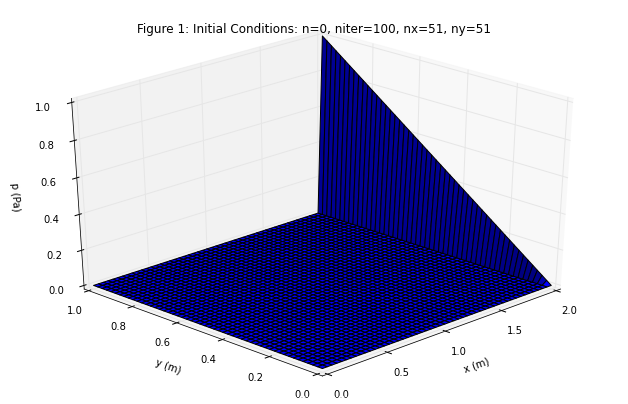

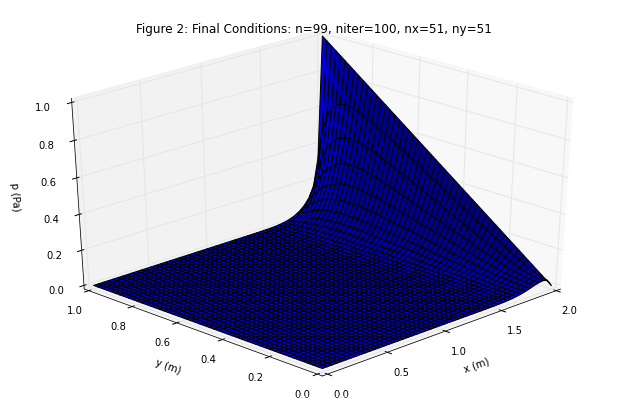

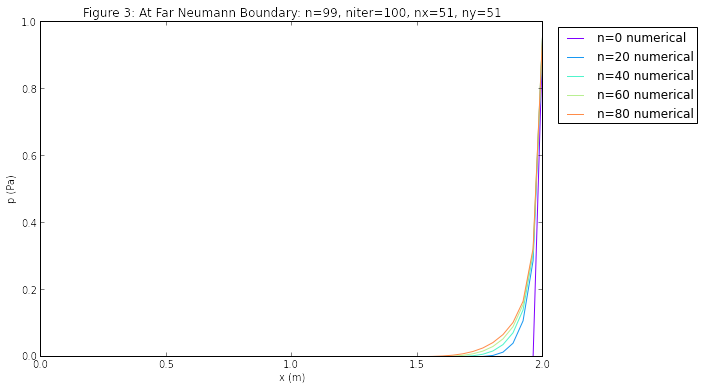

In [6]:
plot_3D(p1,x1,y1,0,'Figure 1: Initial Conditions: n=0, niter=100, nx=51, ny=51','p (Pa)')
plot_3D(p1,x1,y1,99,'Figure 2: Final Conditions: n=99, niter=100, nx=51, ny=51','p (Pa)')
plot_2D(p1,x1,99,'Figure 3: At Far Neumann Boundary: n=99, niter=100, nx=51, ny=51')

***

# Introduce Relative Error

* The above shows that the numerical algorithm works, but depends on the number of iterations for convergence.
* I want to remove this dependence and use an error. I define the error like this (the denominator is n+1 to avoid divide by zero):

$$ \text{Relative Error} = {
{\sum_{n=0}^{n=n_{max}}(\left\vert p_{n+1} \right\vert - \left\vert p_{n} \right\vert)} \over  {\sum_{n=0}^{n=n_{max}}(\left\vert p_{n+1} \right\vert}
}$$

* So now we need a target Relative Error, so choose $1 \times 10^{-2}$ 

* This changes the pseudo-code a bit.

* For safety we can still include the maximum number of iterations, but maybe increase it so that the while loop determines what happens?

* We also need a new plotting function, as we need to step through less iterations in 2D.

## Pseudo-code 2


    error_target=1*10^-2
    niter = 500

    # Numerical Computation

      while error is greater than error_target 
         for n between 0 and niter-1
            for i between 1 and nx-1
               for j between 1 and ny-1
                  p(i,j,n+1) = { dy^2 * [ p(i+1,j,n)+p(i-1,j,n) ] + 
                                 dx^2 * [ p(i,jpos(j),n)+p(i,jneg(j),n) ] } 
                                 / {2(dx^2 + dy^2)}
                  error = [ sum(abs(p(i,j,n+1)-abs(p(i,j,n)) ] / sum(abs(p(i,j,n+1)))

## Implement Algorithm in Python 2


In [2]:
def laplace_equation_numerical_2(error_target, niter, nx, ny, xmax, ymax):

    """
    Returns the velocity field and distance for 2D linear convection
    """
    # Increments:
    dx = xmax/(nx-1)
    dy = ymax/(ny-1)

    # Initialise data structures:
    import numpy as np
    p = np.zeros(((nx,ny,niter)))
    x = np.zeros(nx)
    y = np.zeros(ny)
    jpos = np.zeros(ny)
    jneg = np.zeros(ny)

    # X Loop
    for i in range(0,nx):
      x[i] = i*dx

    # Y Loop
    for j in range(0,ny):
      y[j] = j*dy

    # Initial conditions
    p[:,:,0] = 0

    # Dirichlet Boundary Conditions:

    # p boundary, left:
    p[0,:,:] = 0

    # p boundary, right:
    for j in range(0,ny):
      p[nx-1,j,:] = y[j] 

    # von Neumann Boundary Conditions:

    # Values for correction at boundaries:
    for j in range(0,ny):
      jpos[j] = j + 1
      jneg[j] = j - 1

    # Set Reflection: 
    jpos[ny-1] = ny-2 
    jneg[0] = 1 

    while True: 
      for n in range(0,niter-1):
        for i in range(1,nx-1):
          for j in range(0,ny):
            p[i,j,n+1] = (( dy**2 * ( p[i+1,j,n]+p[i-1,j,n] ) 
                   + dx**2 * ( p[i,jpos[j],n]+p[i,jneg[j],n] ) ) 
                   / (2*(dx**2 + dy**2)))
            
        error = (np.sum(np.abs(p[i,j,n+1])-np.abs(p[i,j,n]) ) / 
                    np.sum(np.abs(p[i,j,n+1]) ))
        print "n = " + str(n) + " completed"
        if(error < error_target):
          break
      break
            
    return p, x, y

In [8]:
p2, x2, y2 = laplace_equation_numerical_2(1.0e-2, 500, 51, 26, 2.0, 1.0)

n = 0 completed
n = 1 completed
n = 2 completed
n = 3 completed
n = 4 completed
n = 5 completed
n = 6 completed
n = 7 completed
n = 8 completed
n = 9 completed
n = 10 completed
n = 11 completed
n = 12 completed
n = 13 completed
n = 14 completed
n = 15 completed
n = 16 completed


In [9]:
def plot_2D_2(p,x,nt,title):
    """
    Plots the 1D velocity field
    """

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    plt.figure()
    ax=plt.subplot(111)
    colour=iter(cm.rainbow(np.linspace(0,1,nt+1)))   
    for n in range(0,nt+1,1):
        c=next(colour)
        ax.plot(x,p[:,-1,n],linestyle='-',c=c,label='n='+str(n)+' numerical')
    box=ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*1.5,box.height*1.5])
    ax.legend( bbox_to_anchor=(1.02,1), loc=2)
    plt.xlabel('x (m)')
    plt.ylabel('p (Pa)')
    plt.ylim([0,1.0])
    plt.xlim([0,2.0])
    plt.title(title)
    plt.show()

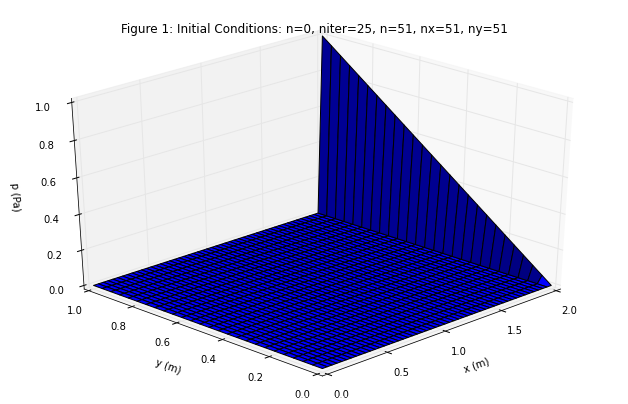

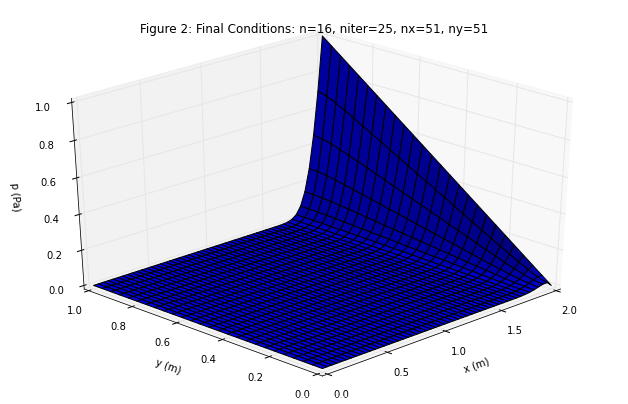

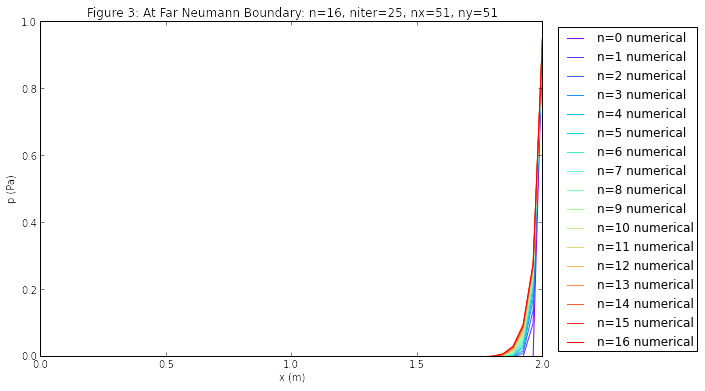

In [21]:
plot_3D(p2,x2,y2,0,'Figure 1: Initial Conditions: n=0, niter=25, n=51, nx=51, ny=51','p (Pa)')
plot_3D(p2,x2,y2,16,'Figure 2: Final Conditions: n=16, niter=25, nx=51, ny=51','p (Pa)')
plot_2D_2(p1,x1,16,'Figure 3: At Far Neumann Boundary: n=16, niter=25, nx=51, ny=51')

***

# Introduce Analytical Solution

* Ok so far so good, we now have a solution that converges in 25 iterations with a defined relative error.
* Now we need to introduce the analytical solution and compare the numerical value at n=24 with the analytical solution - we already did the pseudo code for this

## Implement Analytical Solution in Python

In [11]:
def laplace_equation_analytical(INFINITY, NX, NY, XMAX, YMAX):
    
    from math import pi as PI
    import math as ma
    
    # Initialise data structures
    p_coefficient = np.zeros((NX, NY))
    p_analytical = np.zeros((NX, NY))
    x = np.zeros(NX)
    y = np.zeros(NY)
    
    # Constants
    DX = XMAX/(NX-1)
    DY = YMAX/(NY-1)
    
    # X Loop
    for i in range(0,NX):
        x[i] = i*DX

    # Y Loop
    for j in range(0,NY):
        y[j] = j*DY
    
    # Analytical solution
    for i in range(0, NX):
        for j in range(0, NY):
            p_coefficient[i,j] = ( (ma.sinh(1.0*PI*x[i]) * ma.cos(1.0*PI*y[j]) )
                         / ( ((1.0*PI)**2.0) * ma.sinh(2.0*PI*1.0) ) )

    for m in range(3, INFINITY, 2):
        for i in range(0, NX):
            for j in range(0, NY):
               p_coefficient[i,j] += ( (ma.sinh(m*PI*x[i]) * ma.cos(m*PI*y[j]) )
                         / ( ((m*PI)**2.0) * ma.sinh(2.0*PI*m) ) )
  
    for i in range (0, NX):
        for j in range(0, NY):
            p_analytical[i,j]= (x[i] / 4.0) - (4.0 * p_coefficient[i,j])
        
    return p_analytical, x, y

In [22]:
p3, x3, y3 = laplace_equation_analytical(100, 51, 26, 2.0, 1.0)

In [23]:
def plot_3D_2(p,x,y,title):
    """
    Plots the 2D velocity field
    """

    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig=plt.figure(figsize=(11,7),dpi=100)
    ax=fig.gca(projection='3d')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('p (Pa)')
    ax.set_xlim(0,2)
    ax.set_ylim(0,1)
    ax.view_init(30,225)
    Y,X=np.meshgrid(y,x) #note meshgrid uses y,x not x,y!!!
    surf=ax.plot_surface(X,Y,p[:,:], rstride=1, cstride=1)
    plt.title(title)
    plt.show()

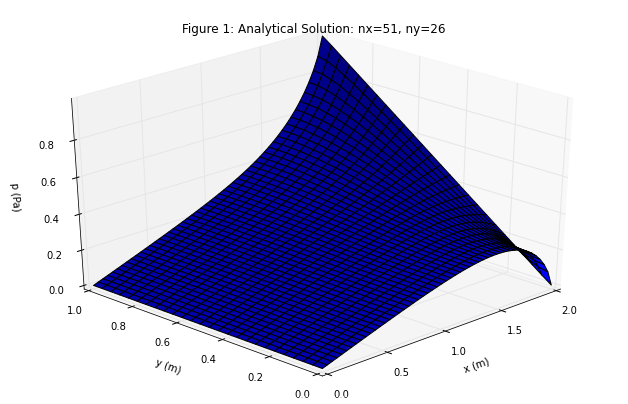

In [24]:
plot_3D_2(p3,x3,y3,'Figure 1: Analytical Solution: nx=51, ny=26')

***

# Why doesn't the analytical solution agree with the numerical solution?

* Possible cause: the residual error is large in the numerical solution
* We also think we can solve this equation more efficiently

## Numerical scheme

* 2nd order CD in space

## Discrete equation

$$ {{p_{i+1,j}^n -2p_{i,j}^n + p_{i-1,j}^n} \over \Delta x^2} + 
{{p_{i,j+1}^n -2p_{i,j}^n + p_{i,j-1}^n} \over \Delta y^2} = 0 $$

* Assume $\Delta x = \Delta y = h$

$$ {{p_{i+1,j}^n -2p_{i,j}^n + p_{i-1,j}^n} \over h^2} + 
{{p_{i,j+1}^n -2p_{i,j}^n + p_{i,j-1}^n} \over h^2} = 0 $$

* Introduce false timestepping - 1st order FD in time:

$$ {{p_{i+1,j}^n -2p_{i,j}^n + p_{i-1,j}^n} \over h^2} + 
{{p_{i,j+1}^n -2p_{i,j}^n + p_{i,j-1}^n} \over h^2} = 
{{p_{i,j}^{n+1} - p_{i,j}^n} \over {\Delta t}} $$

## Transpose

$$ p_{i,j}^{n+1} = p_{i,j}^n + r(p_{i+1,j}^{n}+p_{i-1,j}^{n}+p_{i,j+1}^{n}+p_{i,j-1}^{n} -4 p_{i,j}^n)$$
   
where: $r = {{\Delta t} \over {h^2}}$

* The maximum $r$ for stability is 0.25 for this scheme (.....). 
* This will also give the fastest convergence

So the pressure is just the average of it's neighbours:

$$ p_{i,j}^{n+1} = 0.25(p_{i+1,j}^{n}+p_{i-1,j}^{n}+p_{i,j+1}^{n}+p_{i,j-1}^{n})$$

***

# Implement efficient algorithm in Python

In [15]:
def laplace_equation_numerical_3(error_target, niter, nx, ny, xmax, ymax):

    """
    Returns the velocity field and distance for 2D linear convection
    """
    # Increments:
    dx = xmax/(nx-1)
    dy = ymax/(ny-1)

    # Initialise data structures:
    import numpy as np
    p = np.zeros(((nx,ny,niter)))
    x = np.zeros(nx)
    y = np.zeros(ny)
    jpos = np.zeros(ny)
    jneg = np.zeros(ny)

    # X Loop
    for i in range(0,nx):
      x[i] = i*dx

    # Y Loop
    for j in range(0,ny):
      y[j] = j*dy

    # Initial conditions
    p[:,:,0] = 0

    # Dirichlet Boundary Conditions:

    # p boundary, left:
    p[0,:,:] = 0

    # p boundary, right:
    for j in range(0,ny):
      p[nx-1,j,:] = y[j] 

    # von Neumann Boundary Conditions:

    # Values for correction at boundaries:
    for j in range(0,ny):
        jpos[j] = j + 1
        jneg[j] = j - 1

    # Set Reflection: 
    jpos[ny-1] = ny-2 
    jneg[0] = 1 

    while True: 
      for n in range(0,niter-1):
        for i in range(1,nx-1):
          for j in range(0,ny): 
            p[i,j,n+1] = 0.25*( p[i+1,j,n]+p[i-1,j,n]+p[i,jpos[j],n]+p[i,jneg[j],n] )
            
        error = (np.sum(np.abs(p[i,j,n+1])-np.abs(p[i,j,n]) ) / 
                    np.sum(np.abs(p[i,j,n+1]) ))
        
        if(error < error_target):
          print "n = " + str(n) + " completed"
          break
      break
            
    return p, x, y

## Improvements in the Parameters

* I increased the maximum number of iterations to 3000
* I reduced the relative error to $1 \times 10^{-6}$

In [42]:
p4, x4, y4 = laplace_equation_numerical_3(1.0e-6, 5000, 51, 26, 2.0, 1.0)

n = 3129 completed


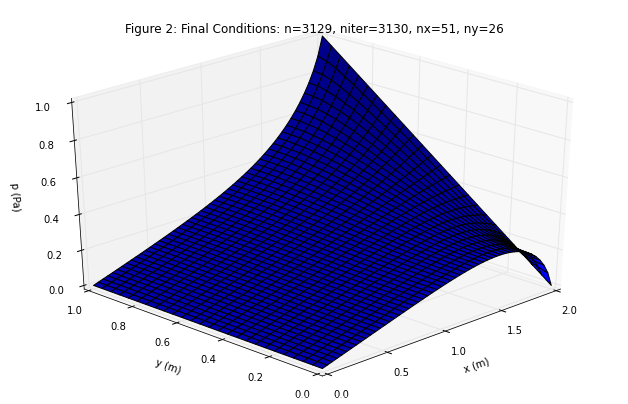

In [43]:
plot_3D(p4,x4,y4,3129,'Figure 2: Final Conditions: n=3129, niter=3130, nx=51, ny=26','p (Pa)')

***

# Compare Improved Results with the Analytical Solution

* This is clearly much better than before, so it's worth comparing the numerical and analytical solutions

In [33]:
def plot_diffusion(p4,p3,x4,NY,TIME,TITLE):
   """
   Plots the 1D velocity field
   """

   import matplotlib.pyplot as plt
   import matplotlib.cm as cm
   plt.figure()
   ax=plt.subplot(111)
   colour=iter(cm.rainbow(np.linspace(0,5,NY)))
   for j in range(0,NY,5):
      c=next(colour)
      ax.plot(x4,p4[:,j,TIME],'ko', markerfacecolor='none', alpha=0.5, label='j='+str(j)+' numerical')
      ax.plot(x4,p3[:,j],linestyle='-',c=c,label='j='+str(j)+' analytical')
   box=ax.get_position()
   ax.set_position([box.x0, box.y0, box.width*1.5,box.height*1.5])
   ax.legend( bbox_to_anchor=(1.02,1), loc=2)
   plt.xlabel('x (m)')
   plt.ylabel('p (Pa)')
   #plt.ylim([0,8.0])
   #plt.xlim([0,2.0*PI])
   plt.title(TITLE)
   plt.show()

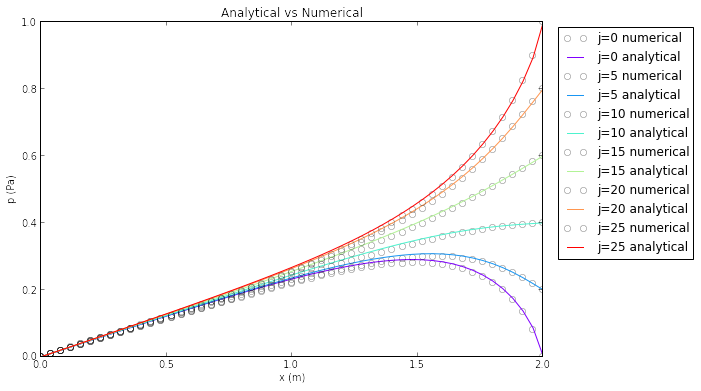

In [44]:
plot_diffusion(p4,p3,x4,26,3129,'Analytical vs Numerical')

# Analytical solution vs the numerical solution

* It was important to arrive at an efficient algorithm to allow a large number of iterations or small accuracy $1 \times 10^{-6}$ or large number of iterations 5000
* Ensuring the spatial steps matched was important for this algorithm to apply
* The accuracy of the numerical solution is heavily dependent on the number of iterations or the relative error (whichever is limiting) **especially important where the values in the solution are small and not changing very much**

# Notes

1) Relation between physics and numerics

* Laplace operator is typical for diffusion, diffusion is an isotropic phenomenon.

* It has to be discretised with a central difference - numerics must be consistent with the physics that it represents. 

* Convection is anisotropic so numerical scheme must be directionally biased.

2) Numerical scheme

* Second order CD in both x and y is the most widely used numerical scheme for $ \nabla^2 $

* Also known as "five point difference operator"

3) Matrix

* This scheme is an iterative method for a steady state (artificial time variable)

* Let $ \Delta x = \Delta y = h$  then

$$ {{p_{i+1,j}^n -2p_{i,j}^n + p_{i-1,j}^n} \over h^2} + {{p_{i,j+1}^n -2p_{i,j}^n + p_{i,j-1}^n} \over h^2} = 0 $$

* Linear system of equations in **pentadiagonal** coefficient matrix

* Equivalent to Point Jacobi method

<img src="_images/five_points.png">